## retail price optimization

<img src="price.webp" alt="picture" width="450">

*`Background`*

Price optimization is using historical data to identify the most appropriate price of a product or a service that maximizes the company’s profitability. There are numerous factors like demography, operating costs, survey data, etc that play a role in efficient pricing, it also depends on the nature of businesses and the product that is served. 

The business regularly adds/upgrades features to bring more value to the product and this obviously has a cost associated with it in terms of effort, time, and most importantly companies reputation.

As a result, it is important to understand the correct pricing, a little too high, you lose your customers and slight underpricing will result in loss of revenue. Price optimization helps businesses strike the right balance of efficient pricing, achieving profit objectives, and also serve their customers.

*detail columns:*
- product_id=product
- product_category_name=category
- month_year=month and year
- qty=qty sold
- total_price=(qty)x(unit_price)
- freight_price=average freight price
- unit_price=average unit price
- product_name_lenght=length of product name
- product_description_lenght=product description
- product_photos_qty=photos qty
- product_weight_g=weight in grams
- product_score=average product rating
- customers=number of customers in the category
- weekday=number of weekdays in that month
- weekend=number of weekend days in that month
- holiday=no of holidays in that month
- month=month
- year=year
- s=seasonality
- volume=product volume
- comp_1=competitor1 price
- ps1=competitor1 product rating
- fp1=competitor1 freight price
- comp_2=competitor2 price
- ps2=competitor2 product rating
- fp2=competitor2 freight price
- comp_3=competitor3 price
- ps3=competitor3 product rating
- fp3=competitor3 freight price
- lag_price=previous month price of the product

`packages`

In [1]:
# general
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
import os, yaml, requests
import numpy as np

# temporal decompose
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

# stas models
import statsmodels.api as sm
from statsmodels.stats import descriptivestats

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from pandas.plotting import scatter_matrix

`functions`

In [2]:
def read_yaml_file(yaml_file):
    """ load yaml cofigurations """

    config = None
    try:
        with open(yaml_file, 'r') as f:
            config = yaml.safe_load(f)
    except:
        raise FileNotFoundError('Couldnt load the file')

    return config


def get_db_conn_post(creds_file):
    """ Get an authenticated psycopg db connection, given a credentials file"""
    creds = read_yaml_file(creds_file)['db']

    connection = psycopg2.connect(
        user=creds['user'],
        password=creds['pass'],
        host=creds['host'],
        port=creds['port'],
        database=creds['db']
    )

    return connection

In [3]:
def temporal_analysis(data, product_category='all', is_product=True):
    
    if is_product:
        if product_category!='all':
            condition_product=data['product_id']==product_category
            df_temp_function=data[condition_product][['month_year', 'product_id', 'qty_sold']].\
                                                                            groupby(by=['month_year', 'product_id'], 
                                                                                    as_index=False).agg('sum')
    
            df_temp_function['month_year']=pd.to_datetime(df_temp_function['month_year'], dayfirst=True)
            df_temp_function.set_index('month_year', inplace=True)
            
        else:
            df_temp_function=data[['month_year', 'product_id', 'qty_sold']].\
                                                            groupby(by=['month_year', 'product_id'], 
                                                                    as_index=False).agg('sum')
            
            df_temp_function['month_year']=pd.to_datetime(df_temp_function['month_year'], dayfirst=True)
            df_temp_function.set_index('month_year', inplace=True)
                                
    else:
        if product_category!='all':
            condition_category=data['category']==product_category
            df_temp_function=data[condition_category][['month_year', 'product_id', 'qty_sold']].\
                                                                                    groupby(by=['month_year', 'product_id'], 
                                                                                            as_index=False).agg('sum')
    
            df_temp_function['month_year']=pd.to_datetime(df_temp_function['month_year'], dayfirst=True)
            df_temp_function.set_index('month_year', inplace=True)
            
        else:
            df_temp_function=data[['month_year', 'product_id', 'qty_sold']].\
                                                            groupby(by=['month_year', 'product_id'], 
                                                                    as_index=False).agg('sum')
            
            df_temp_function['month_year']=pd.to_datetime(df_temp_function['month_year'], dayfirst=True)
            df_temp_function.set_index('month_year', inplace=True)
                    
    # =====================================================================================
    # =====================================================================================
    # plot data
    plt.style.use('ggplot')
    y=df_temp_function['qty_sold'].resample('MS').sum()
    y.plot(figsize = (16,4), grid=True, color='#3468C0')
    plt.title('qty sold - ' + product_category)
    plt.show()
    
    rcParams['figure.figsize'] = 18, 8
    decomposition = sm.tsa.seasonal_decompose(y, period = 6)
    fig = decomposition.plot()    
    plt.show()

`get data`

In [4]:
db_conn_post = get_db_conn_post("key_postgresql.yaml")

In [5]:
q = """
    select
            *
    from
            kaggle_data.price_optimization.data_raw;
"""

In [6]:
df_raw = pd.read_sql(sql = q, con = db_conn_post)
df_raw.head(3)

C:\Users\migue\AppData\Local\Temp/ipykernel_8040/3493397046.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_raw = pd.read_sql(sql = q, con = db_conn_post)


,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,...,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,01-05-2017,1,45.95,15.100000,45.95,39,161,2,...,89.9,3.9,15.011897,215.0,4.4,8.760000,45.95,4.0,15.100000,45.90
1,bed1,bed_bath_table,01-06-2017,3,137.85,12.933333,45.95,39,161,2,...,89.9,3.9,14.769216,209.0,4.4,21.322000,45.95,4.0,12.933333,45.95
2,bed1,bed_bath_table,01-07-2017,6,275.70,14.840000,45.95,39,161,2,...,89.9,3.9,13.993833,205.0,4.4,22.195932,45.95,4.0,14.840000,45.95


The initial step involves delving deep into the data and scrutinizing various aspects. The foremost task is to ascertain whether the data contains any null valuesand the info about it.

In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  676 non-null    object 
 1   product_category_name       676 non-null    object 
 2   month_year                  676 non-null    object 
 3   qty                         676 non-null    int64  
 4   total_price                 676 non-null    float64
 5   freight_price               676 non-null    float64
 6   unit_price                  676 non-null    float64
 7   product_name_lenght         676 non-null    int64  
 8   product_description_lenght  676 non-null    int64  
 9   product_photos_qty          676 non-null    int64  
 10  product_weight_g            676 non-null    int64  
 11  product_score               676 non-null    float64
 12  customers                   676 non-null    int64  
 13  weekday                     676 non

In [8]:
df_raw.isnull().sum()

product_id                    0
product_category_name         0
month_year                    0
qty                           0
total_price                   0
freight_price                 0
unit_price                    0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_score                 0
customers                     0
weekday                       0
weekend                       0
holiday                       0
month                         0
year                          0
s                             0
volume                        0
comp_1                        0
ps1                           0
fp1                           0
comp_2                        0
ps2                           0
fp2                           0
comp_3                        0
ps3                           0
fp3                           0
lag_price                     0
dtype: int64

In [9]:
df_raw.describe()

,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_score,customers,...,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
count,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,...,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000
mean,14.495562,1422.708728,20.682270,106.496800,48.720414,767.399408,1.994083,1847.498521,4.085503,81.028107,...,79.452054,4.159467,18.597610,92.930079,4.123521,18.620644,84.182642,4.002071,17.965007,107.399684
std,15.443421,1700.123100,10.081817,76.182972,9.420715,655.205015,1.420473,2274.808483,0.232021,62.055560,...,47.933358,0.121652,9.406537,49.481269,0.207189,6.424174,47.745789,0.233292,5.533256,76.974657
min,1.000000,19.900000,0.000000,19.900000,29.000000,100.000000,1.000000,100.000000,3.300000,1.000000,...,19.900000,3.700000,0.095439,19.900000,3.300000,4.410000,19.900000,3.500000,7.670000,19.850000
25%,4.000000,333.700000,14.761912,53.900000,40.000000,339.000000,1.000000,348.000000,3.900000,34.000000,...,49.910000,4.100000,13.826429,53.900000,4.100000,14.485000,53.785714,3.900000,15.042727,55.668750
50%,10.000000,807.890000,17.518472,89.900000,51.000000,501.000000,1.500000,950.000000,4.100000,62.000000,...,69.900000,4.200000,16.618984,89.990000,4.200000,16.811765,59.900000,4.000000,16.517110,89.900000
75%,18.000000,1887.322500,22.713558,129.990000,57.000000,903.000000,2.000000,1850.000000,4.200000,116.000000,...,104.256549,4.200000,19.732500,117.888889,4.200000,21.665238,99.990000,4.100000,19.447778,129.990000
max,122.000000,12095.000000,79.760000,364.000000,60.000000,3006.000000,8.000000,9750.000000,4.500000,339.000000,...,349.900000,4.500000,57.230000,349.900000,4.400000,57.230000,255.610000,4.400000,57.230000,364.000000


*create a copy form the original data*

In [10]:
df=df_raw.copy()

number of categories

In [11]:
len(df_raw['product_category_name'].unique())

9

number of products

In [12]:
len(df_raw['product_id'].unique())

52

*rename columns*

In [13]:
cols=['product_id','category','month_year','qty_sold','total_price','freight_price','unit_price',
'product_name_lenght','product_description_lenght','product_photos_qty','product_weight_g',
'product_score','customers','weekday','weekend','holiday','month','year','seasonality','volume',
'competitor1_price','competitor1_product_score','competitor1_freight_price',
'competitor2_price','competitor2_product_score','competitor2_freight_price',
'competitor3_price','competitor3_product_score','competitor3_freight_price',
'lag_price']

df.rename(columns=dict(zip(df.columns, cols)), inplace=True)
df.head(1)

,product_id,category,month_year,qty_sold,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,...,competitor1_price,competitor1_product_score,competitor1_freight_price,competitor2_price,competitor2_product_score,competitor2_freight_price,competitor3_price,competitor3_product_score,competitor3_freight_price,lag_price
0,bed1,bed_bath_table,01-05-2017,1,45.95,15.1,45.95,39,161,2,...,89.9,3.9,15.011897,215.0,4.4,8.76,45.95,4.0,15.1,45.9


*while it's widely acknowledged that correlation doesn't imply causality, it does offer valuable insights into the relationships between different variables. In our present scenario, we can observe correlations among **prices**. For instance, we can examine whether there's a **leader-follower price strategy** or if product scores affect sales volumes*

<img src="correlation_causation.avif" alt="causation" width="350">

In [14]:
corr_matrix = df.select_dtypes(include=['float64', 'int64']).corr()
corr_matrix["unit_price"].sort_values(ascending = False)

unit_price                    1.000000
lag_price                     0.994453
competitor2_price             0.466459
total_price                   0.409001
competitor3_price             0.383780
competitor1_price             0.317113
product_description_lenght    0.280176
freight_price                 0.203659
competitor1_product_score     0.197425
product_weight_g              0.112958
competitor2_product_score     0.085436
product_photos_qty            0.076990
customers                     0.043391
product_score                 0.042162
competitor2_freight_price     0.026601
competitor3_freight_price     0.019461
holiday                       0.012573
weekend                      -0.000042
month                        -0.004249
competitor1_freight_price    -0.004518
weekday                      -0.011949
seasonality                  -0.016552
year                         -0.068072
qty_sold                     -0.103432
product_name_lenght          -0.170613
volume                   

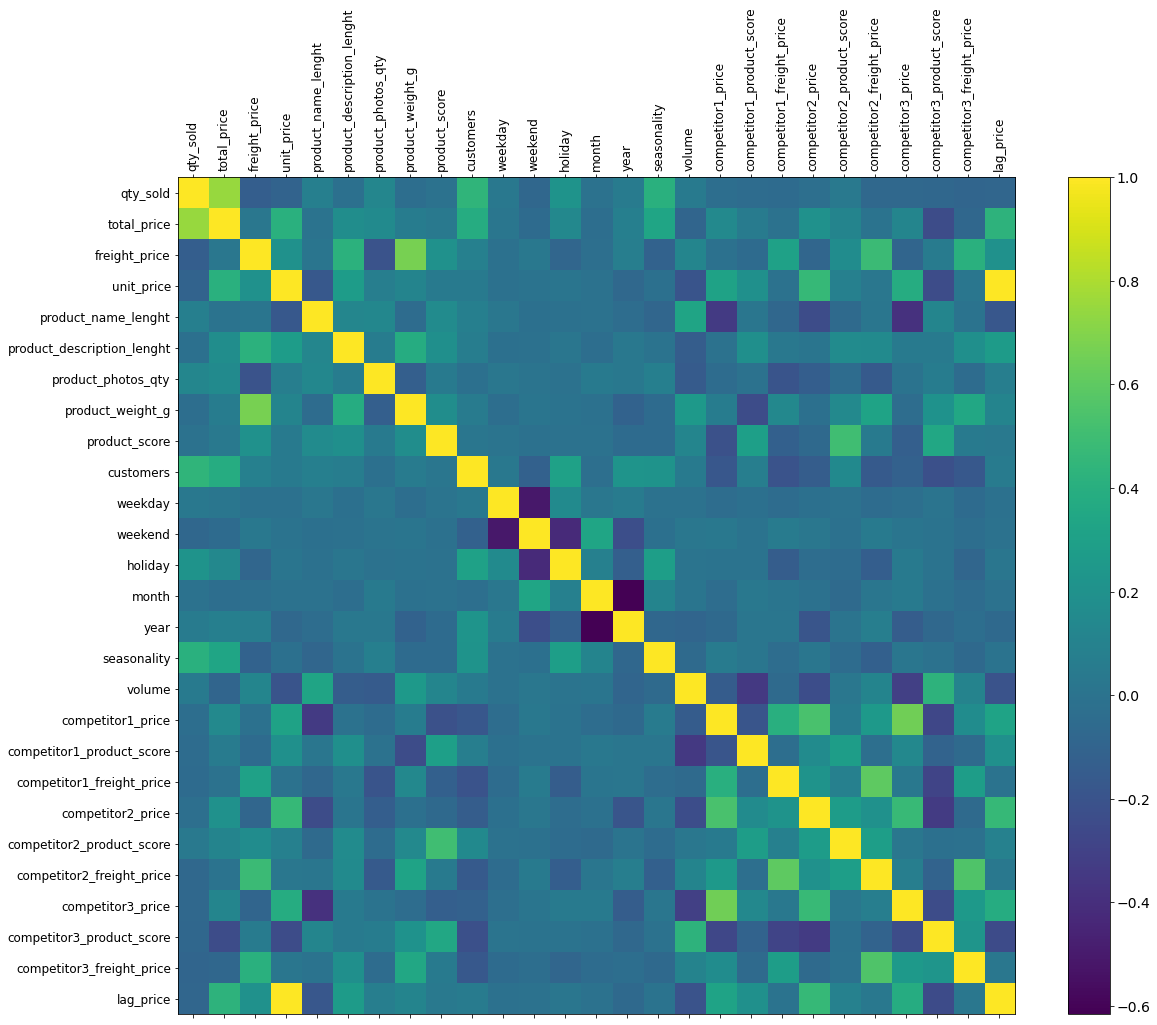

In [15]:
f = plt.figure(figsize=(19, 15))
plt.matshow(corr_matrix, fignum=f.number)
plt.xticks(range(corr_matrix.shape[1]), corr_matrix.columns, fontsize=12, rotation=90)
plt.yticks(range(corr_matrix.shape[1]), corr_matrix.columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

As we can observe, there seems to be a direct relationship between our unit **price** and that of the competition. In other words, a **higher own price** corresponds to a **higher market price,** suggesting the presence of **price leadership** and follower strategies. However, a deeper analysis is needed to determine who is leading and who is following in this context. Additionally, it's worth noting that this initial overview considers the entire portfolio.

Another factor to consider is the relationship between **price and volume.** We may observe that it does not necessarily impact sales, but it's important to note that we are taking into account all product categories.

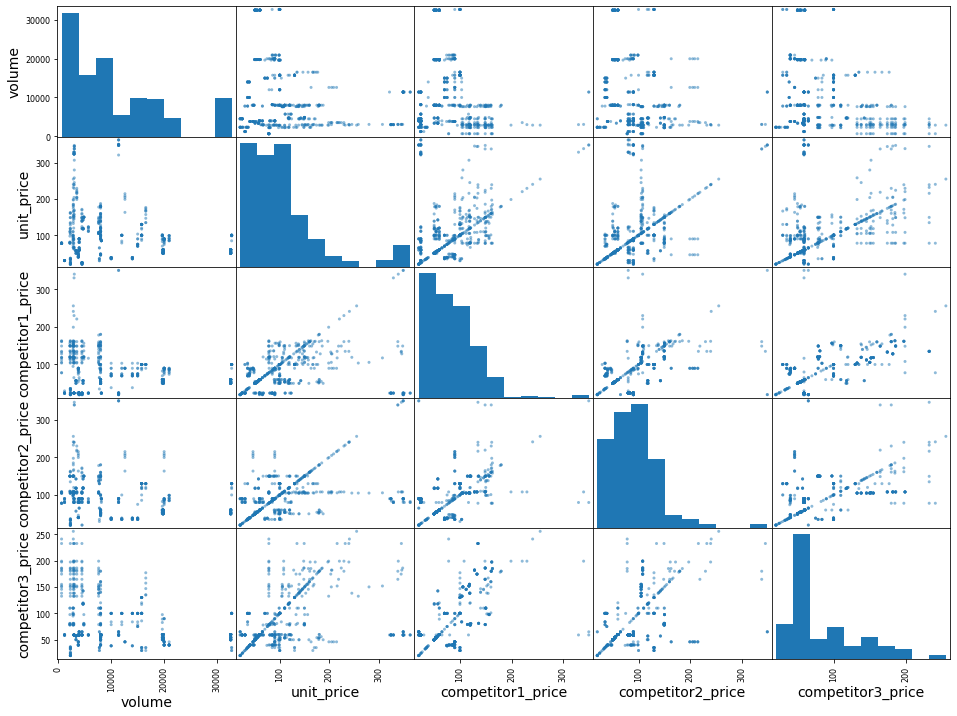

In [16]:
features = ['volume', 
            'unit_price', 'competitor1_price', 'competitor2_price', 'competitor3_price']
scatter_matrix(df[features], figsize = (16, 12))
plt.show()

Now, considering the product rating, there is a slight correlation with competitors 2 and 3. However, when it comes to sales, there isn't a clear correlation indicating that higher ratings lead to increased volume.

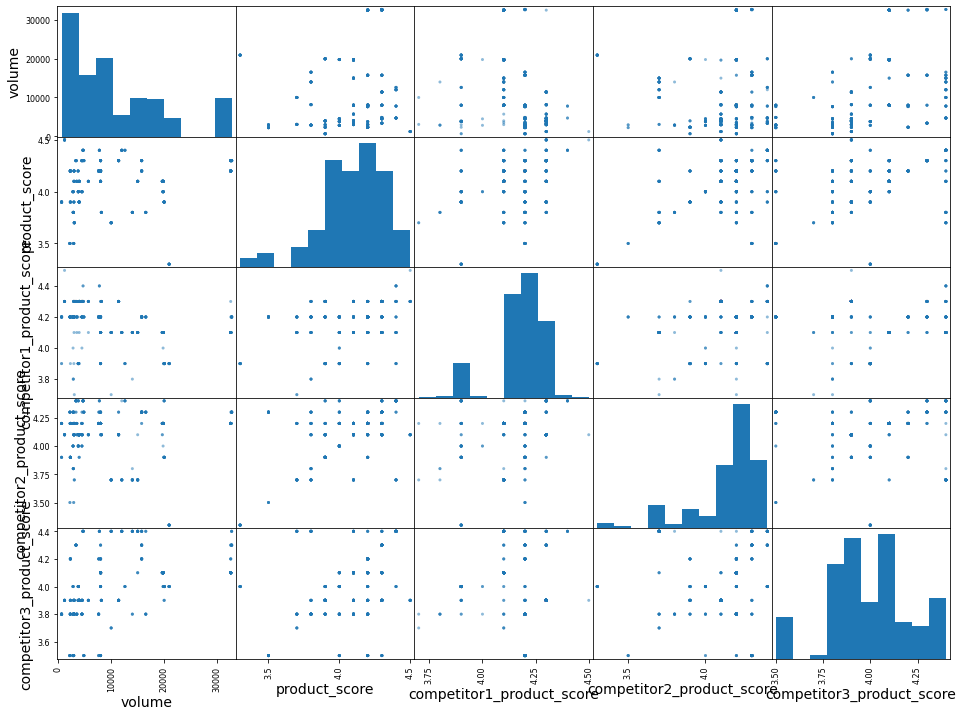

In [17]:
features = ['volume', 'product_score', 
            'competitor1_product_score', 'competitor2_product_score', 'competitor3_product_score']
scatter_matrix(df[features], figsize = (16, 12))
plt.show()

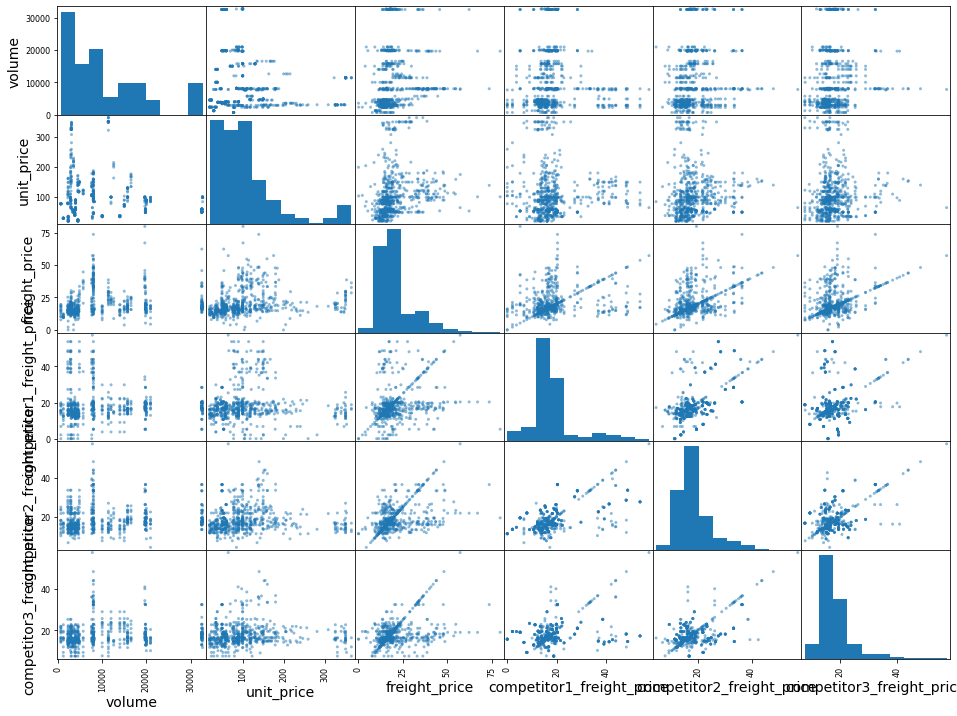

In [18]:
features = ['volume', 'unit_price', 'freight_price',
            'competitor1_freight_price', 'competitor2_freight_price', 'competitor3_freight_price']
scatter_matrix(df[features], figsize = (16, 12))
plt.show()

Now we are examining freight costs as a factor influencing demand. It's possible that high freight costs may deter customers from purchasing items. However, upon initial visual analysis, there doesn't appear to be evidence supporting this hypothesis. The relationship between freight costs and market dynamics seems to be more complex than anticipated.

`most sold items`

In [19]:
cols=['product_id', 'qty_sold']
sales_summary=df[cols].\
                groupby(by=['product_id'], as_index=False).\
                agg('sum').\
                sort_values(by=['qty_sold'], ascending=False)

sales_summary['pct_share']=round((sales_summary['qty_sold']/sales_summary['qty_sold'].sum())*100, 4)
sales_summary['share_cumsum']=sales_summary['pct_share'].cumsum()
sales_summary.head(2)

,product_id,qty_sold,pct_share,share_cumsum
19,furniture2,527,5.3781,5.3781
1,bed2,487,4.9699,10.3480


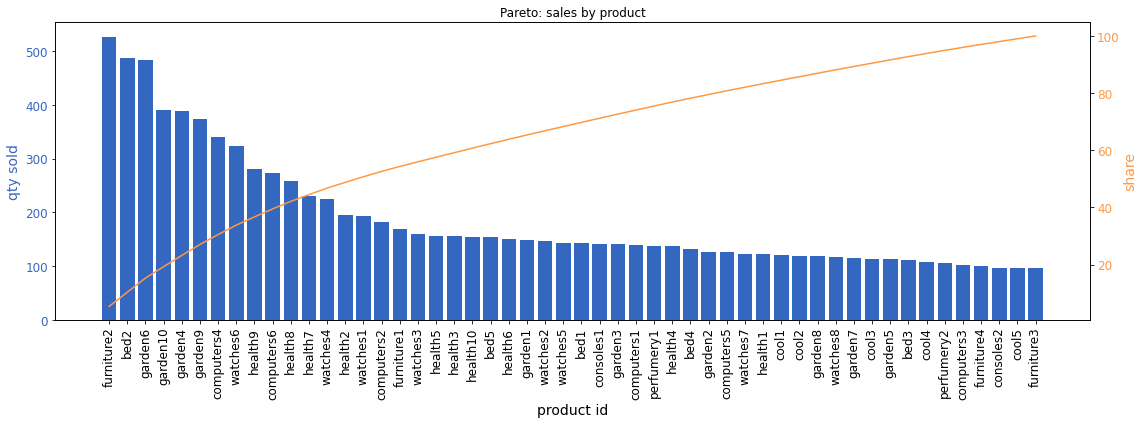

In [20]:
fig, ax1 = plt.subplots(figsize=(16, 6))

ax1.set_xlabel('product id')
ax1.set_ylabel('qty sold', color='#3468C0')
ax1.bar(sales_summary['product_id'], sales_summary['qty_sold'], color='#3468C0')
ax1.tick_params(axis='y', labelcolor='#3468C0')
ax1.tick_params(axis='x', rotation=90)

ax2 = ax1.twinx()  
ax2.set_ylabel('share', color='#FF9843')
ax2.plot(sales_summary['product_id'], sales_summary['share_cumsum'], color='#FF9843')
ax2.tick_params(axis='y', labelcolor='#FF9843')

plt.title('Pareto: sales by product')
fig.tight_layout()
plt.show()

As observed in the chart above, 3 significant items account for **15%** of total sales, while 10 items collectively contribute to **39%** of total sales. Hence, it's crucial to delve deeper into these items to gain insights and innovate in **pricing** strategies. It's essential to note that we are examining sales in terms of quantity rather than revenue.

`most sold categories`

In [21]:
cols=['category', 'qty_sold']
sales_summary_cat=df[cols].\
                    groupby(by=['category'], as_index=False).\
                    agg('sum').\
                    sort_values(by=['qty_sold'], ascending=False)

sales_summary_cat['pct_share']=round((sales_summary_cat['qty_sold']/sales_summary_cat['qty_sold'].sum())*100, 4)
sales_summary_cat['share_cumsum']=sales_summary_cat['pct_share'].cumsum()
sales_summary_cat.head(2)

,category,qty_sold,pct_share,share_cumsum
5,garden_tools,2398,24.4719,24.4719
6,health_beauty,1842,18.7978,43.2697


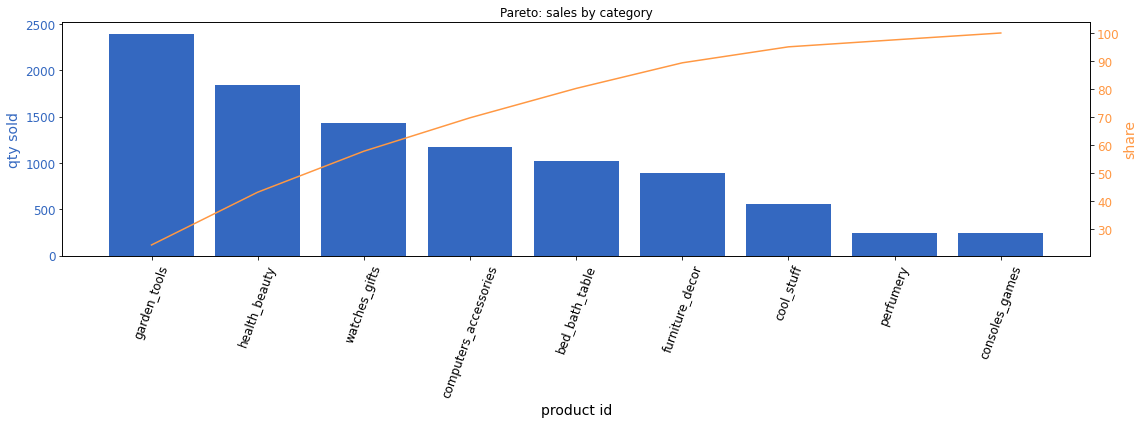

In [22]:
fig, ax1 = plt.subplots(figsize=(16, 6))

ax1.set_xlabel('product id')
ax1.set_ylabel('qty sold', color='#3468C0')
ax1.bar(sales_summary_cat['category'], sales_summary_cat['qty_sold'], color='#3468C0')
ax1.tick_params(axis='y', labelcolor='#3468C0')
ax1.tick_params(axis='x', rotation=70)

ax2 = ax1.twinx()  
ax2.set_ylabel('share', color='#FF9843')
ax2.plot(sales_summary_cat['category'], sales_summary_cat['share_cumsum'], color='#FF9843')
ax2.tick_params(axis='y', labelcolor='#FF9843')

plt.title('Pareto: sales by category')
fig.tight_layout()
plt.show()

In conjunction with the sales chart for individual items, the chart above displays the top categories, with two of them accounting for over 60% of total sales. Therefore, echoing the previous observation, we must conduct a thorough analysis of the data to gain further insights. Additionally, it's important to emphasize that we are measuring sales quantity rather than revenue.

`categories & products with most profit`

In the raw data, profit information is unavailable. Therefore, we'll use an interval from 20% to 30% for the profit margin for each category. This percentage will be uniformly applied across all categories.

In [23]:
np.random.seed(16)
profit=np.random.randint(low=20, high=30, size=9)

In [24]:
profit_by_category= pd.DataFrame(zip(df['category'].unique(), profit), 
                                 columns=['category', 'profit_pct'])

In [25]:
df=df.merge(profit_by_category, on='category')
df.head(1)

,product_id,category,month_year,qty_sold,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,...,competitor1_product_score,competitor1_freight_price,competitor2_price,competitor2_product_score,competitor2_freight_price,competitor3_price,competitor3_product_score,competitor3_freight_price,lag_price,profit_pct
0,bed1,bed_bath_table,01-05-2017,1,45.95,15.1,45.95,39,161,2,...,3.9,15.011897,215.0,4.4,8.76,45.95,4.0,15.1,45.9,29


In [26]:
df['profit']=df['unit_price']*(df['profit_pct']/100)
df.head(1)

,product_id,category,month_year,qty_sold,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,...,competitor1_freight_price,competitor2_price,competitor2_product_score,competitor2_freight_price,competitor3_price,competitor3_product_score,competitor3_freight_price,lag_price,profit_pct,profit
0,bed1,bed_bath_table,01-05-2017,1,45.95,15.1,45.95,39,161,2,...,15.011897,215.0,4.4,8.76,45.95,4.0,15.1,45.9,29,13.3255


In [27]:
cols=['product_id', 'profit']
profit_summary=df[cols].\
                groupby(by=['product_id'], as_index=False).\
                agg('sum').\
                sort_values(by=['profit'], ascending=False)

profit_summary['pct_share']=round((profit_summary['profit']/profit_summary['profit'].sum())*100, 4)
profit_summary['share_cumsum']=profit_summary['pct_share'].cumsum()
profit_summary.head(2)

,product_id,profit,pct_share,share_cumsum
37,health5,1473.126136,8.5320,8.5320
34,health2,892.687500,5.1702,13.7022


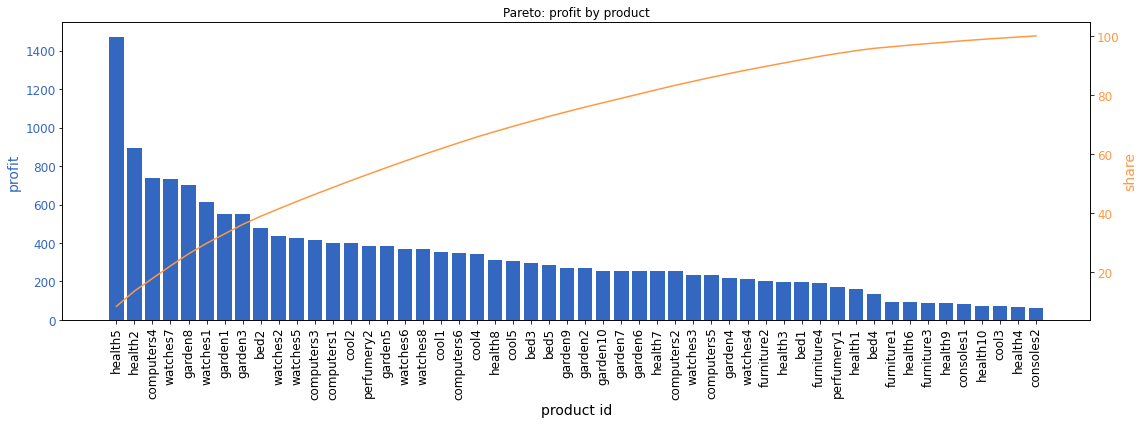

In [28]:
fig, ax1 = plt.subplots(figsize=(16, 6))

ax1.set_xlabel('product id')
ax1.set_ylabel('profit', color='#3468C0')
ax1.bar(profit_summary['product_id'], profit_summary['profit'], color='#3468C0')
ax1.tick_params(axis='y', labelcolor='#3468C0')
ax1.tick_params(axis='x', rotation=90)

ax2 = ax1.twinx()  
ax2.set_ylabel('share', color='#FF9843')
ax2.plot(profit_summary['product_id'], profit_summary['share_cumsum'], color='#FF9843')
ax2.tick_params(axis='y', labelcolor='#FF9843')

plt.title('Pareto: profit by product')
fig.tight_layout()
plt.show()

In [29]:
cols=['category', 'profit']
profit_summary_cat=df[cols].\
                    groupby(by=['category'], as_index=False).\
                    agg('sum').\
                    sort_values(by=['profit'], ascending=False)

profit_summary_cat['pct_share']=round((profit_summary_cat['profit']/profit_summary_cat['profit'].sum())*100, 4)
profit_summary_cat['share_cumsum']=profit_summary_cat['pct_share'].cumsum()
profit_summary_cat.head(2)

,category,profit,pct_share,share_cumsum
5,garden_tools,3716.394039,21.5244,21.5244
6,health_beauty,3612.059451,20.9201,42.4445


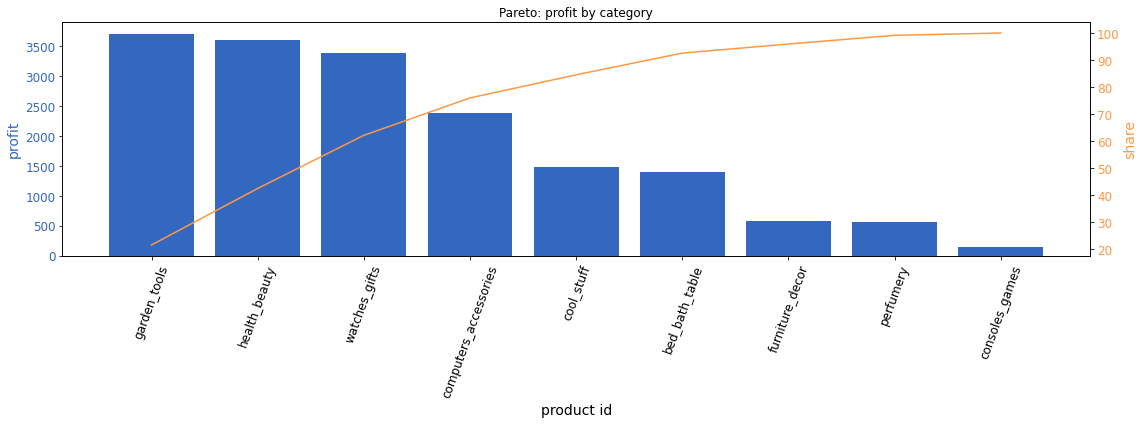

In [30]:
fig, ax1 = plt.subplots(figsize=(16, 6))

ax1.set_xlabel('product id')
ax1.set_ylabel('profit', color='#3468C0')
ax1.bar(profit_summary_cat['category'], profit_summary_cat['profit'], color='#3468C0')
ax1.tick_params(axis='y', labelcolor='#3468C0')
ax1.tick_params(axis='x', rotation=70)

ax2 = ax1.twinx()  
ax2.set_ylabel('share', color='#FF9843')
ax2.plot(profit_summary_cat['category'], profit_summary_cat['share_cumsum'], color='#FF9843')
ax2.tick_params(axis='y', labelcolor='#FF9843')

plt.title('Pareto: profit by category')
fig.tight_layout()
plt.show()

As depicted in the chart, the health5 item stands out as the most profitable, which contrasts with its quantity sold. However, within the most profitable category, the ranking remains consistent. Therefore, it's essential to closely monitor the item with the highest profitability to devise a strategy for enhancing profits while ensuring that the most profitable items remain a priority.

`temporal analysis`

The next step involves delving deeper into the temporal patterns of sales to uncover additional insights, such as identifying potential seasonal trends. This analysis will allow us to explore seasonal patterns beyond the seasonal feature already present.

For this purpose, we will analyze the temporal data of the top 3 selling products and the most significant category in terms of sales.

In [31]:
products_to_analyze = ['health5', 'health2', 'computers4']
categories_to_analyze = ['garden_tools']

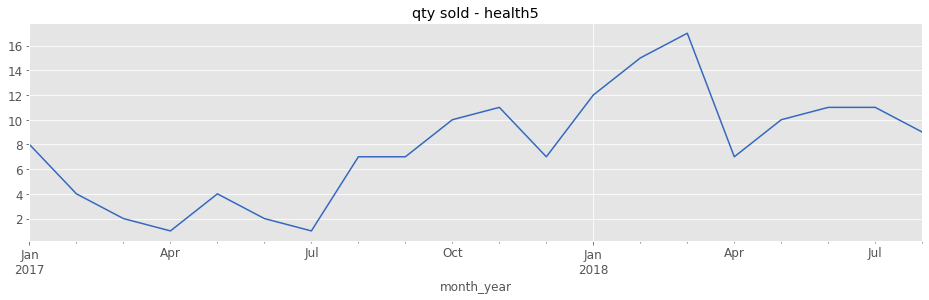

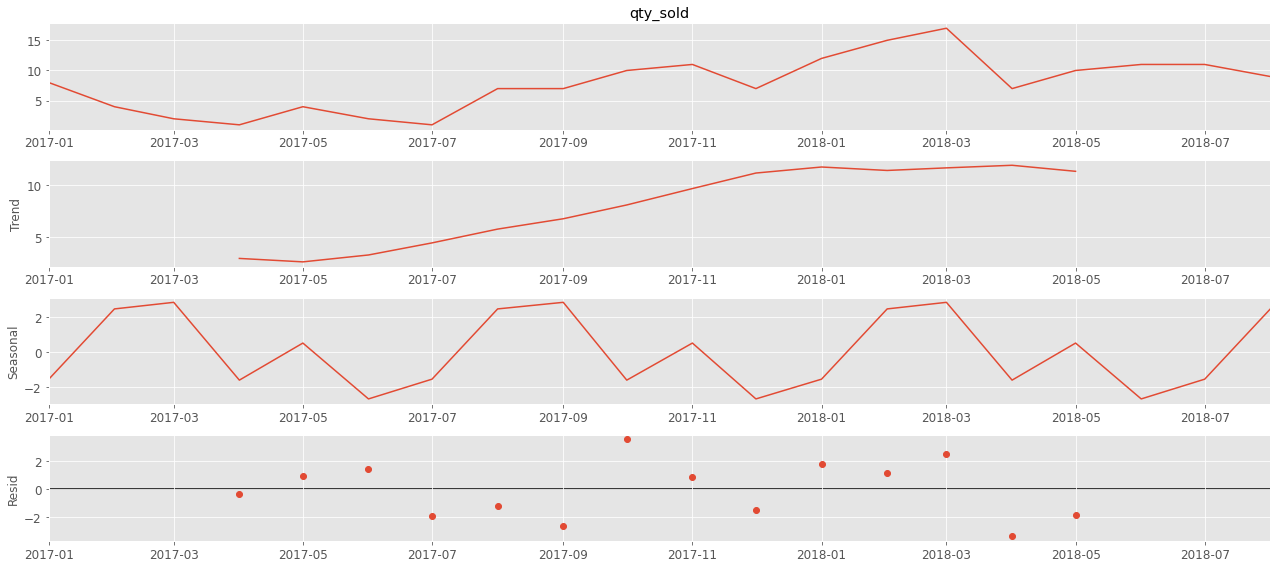

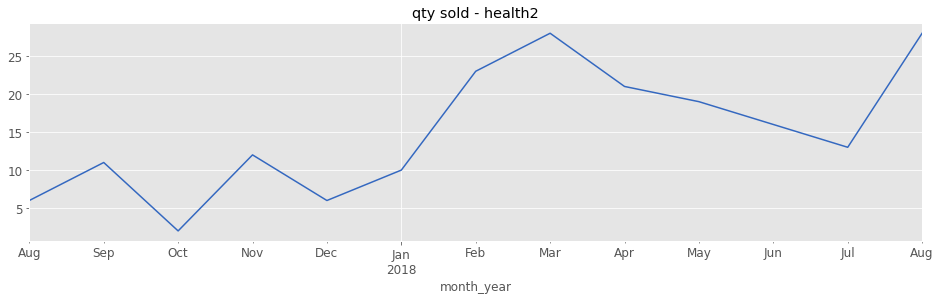

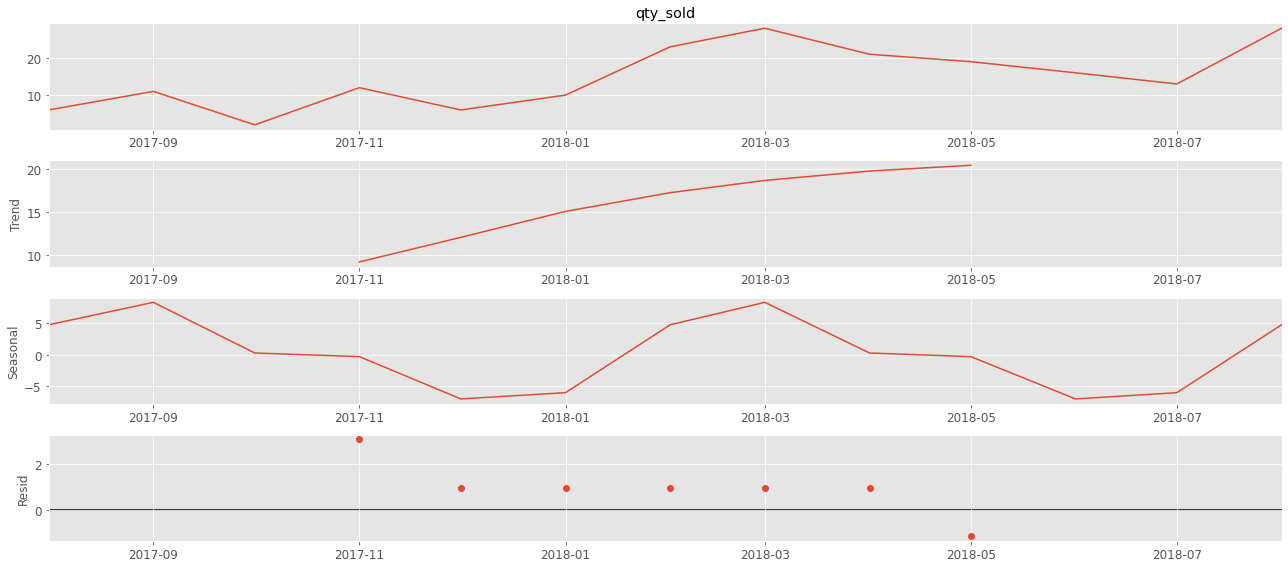

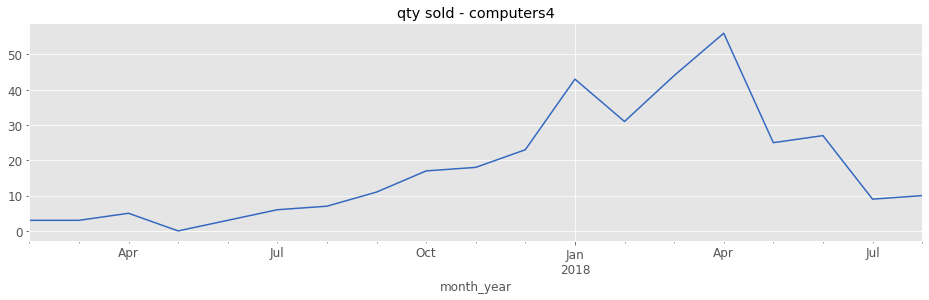

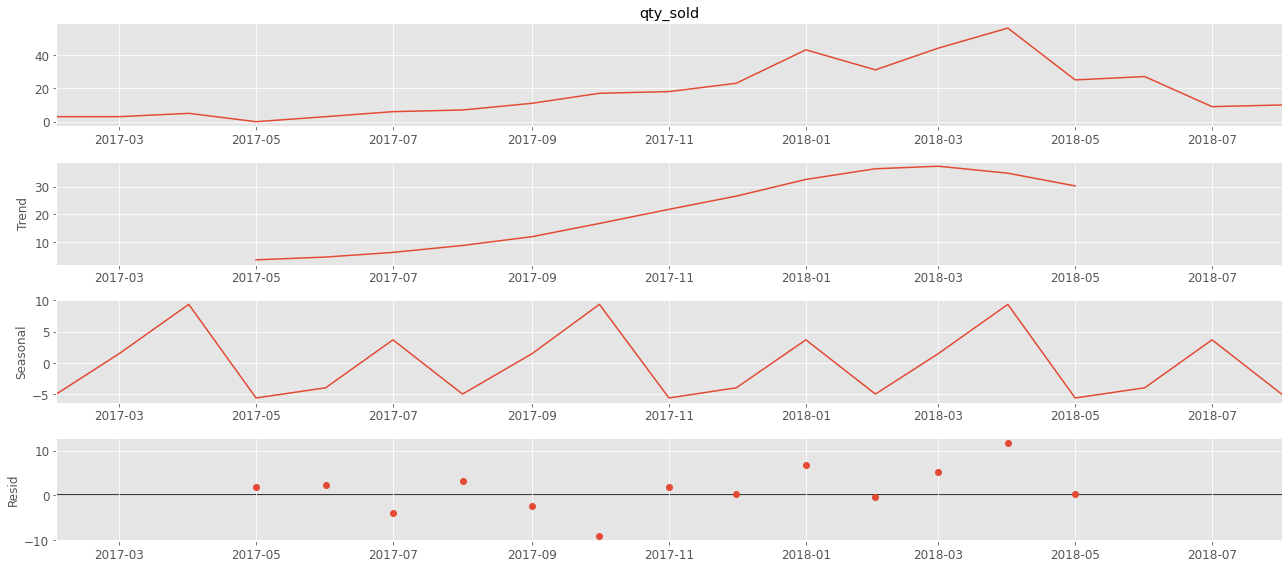

In [32]:
for prod in products_to_analyze:
    temporal_analysis(df, product_category=prod, is_product=True)

As observed in the charts above, the three items experienced growth during the first year, but at least one of them (computers 4) declined in the second half of 2018. However, health2 continued to grow throughout 2018.

Regarding seasonal patterns, there are some indications, but we must exercise caution as these may be a result of aggressive changes in sales strategy. Further investigation is needed to determine if there are any consequences of revenue-related decisions.

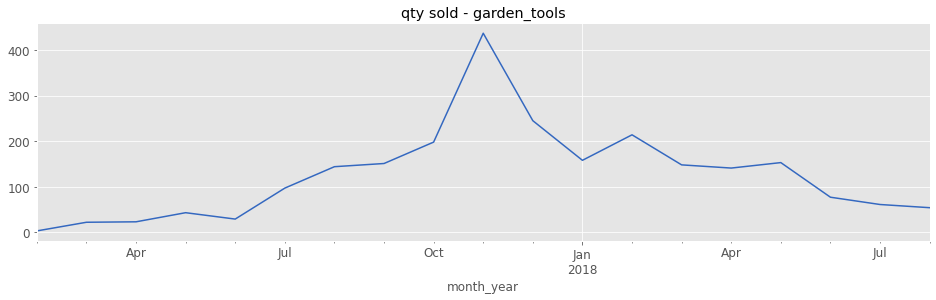

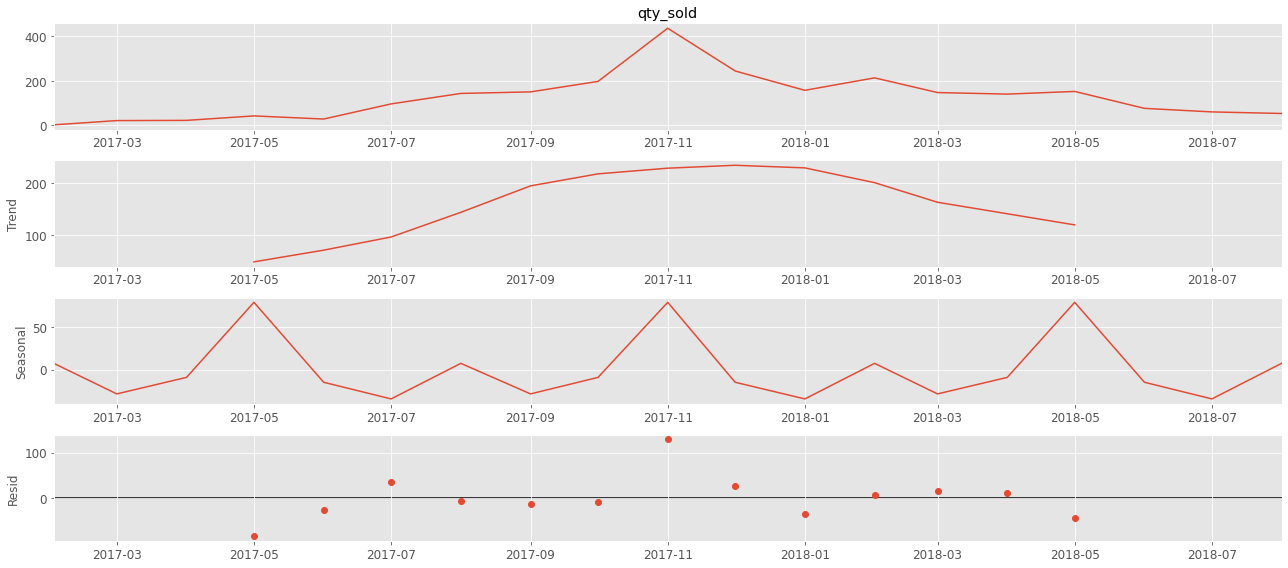

In [33]:
for cat in categories_to_analyze:
    temporal_analysis(df, product_category=cat, is_product=False)

As depicted in the chart above, the top-selling category also experienced a decline throughout 2018. However, upon closer inspection, there appears to be a seasonal pattern characterized by peaks in May and November. It's worth noting that this pattern may be influenced by the peak observed in November 2017.

The subsequent step involves exploring the relationship between sales and unit price.

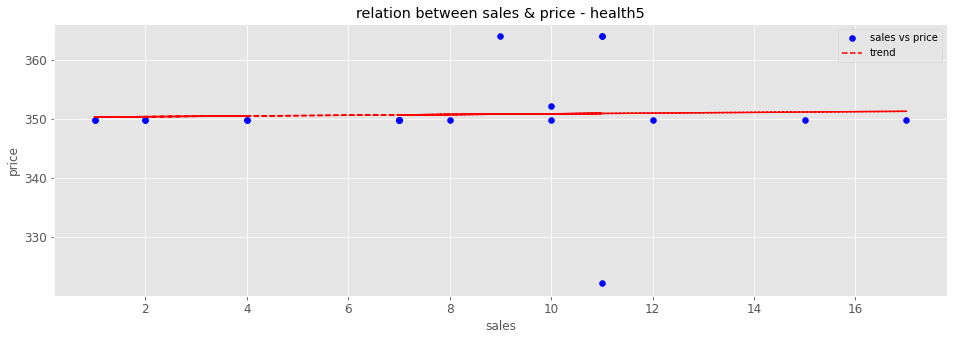

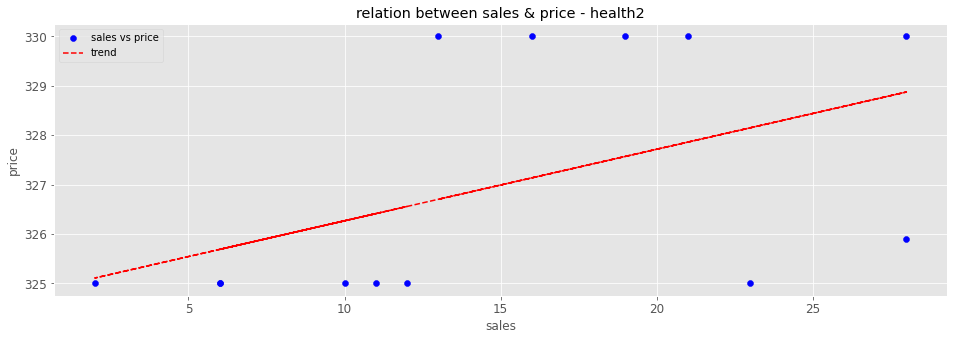

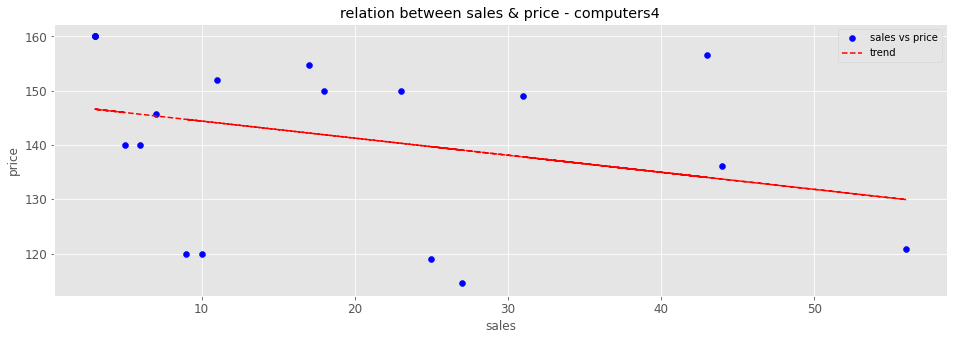

In [34]:
for prod in products_to_analyze:
    condition=df['product_id']==prod
    sales = df[condition]['qty_sold']
    price = df[condition]['unit_price']

    plt.figure(figsize=(16, 5))
    plt.scatter(sales, price, c='blue', label='sales vs price')

    z = np.polyfit(sales, price, 1)
    p = np.poly1d(z)
    plt.plot(sales, p(sales), "r--", label='trend')

    plt.title('relation between sales & price - ' + prod)
    plt.xlabel('sales')
    plt.ylabel('price')
    plt.legend()
    plt.show()

Upon observing the above charts, it appears that items labeled as health articles tend, at least in the data, to be **price inelastic.** This could be attributed to the fact that goods and services in the health sector typically exhibit relatively **inelastic demand.** This implies that changes in prices have a lesser effect on the quantity demanded compared to other goods like computers items in the current example. The primary reason for this is that many health goods and services are deemed necessary or critical for people's well-being and survival. For instance, essential medications, treatments for chronic conditions, or emergency services exhibit little **price sensitivity** as consumers require them regardless of their cost.

`elasticity`

from the charts above, it is evident that certain products display inelastic demand, while one of them exhibits perfectly elastic demand. In the subsequent step, our aim is to ascertain the elasticity of these products.

In [35]:
# scikit learn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# econml 

from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter

# graphs
from networkx.drawing.nx_pydot import to_pydot

In [36]:
print('product to analyze: ', products_to_analyze[0])

product to analyze:  health5


In [37]:
condition=df['product_id']==products_to_analyze[0]
econml_cols=['qty_sold', 'unit_price', 'freight_price', 'product_score', 
             'weekday', 'weekend', 'holiday', 'year', 'month', 
             'competitor1_price', 'competitor1_freight_price', 'competitor1_product_score',
             'competitor2_price', 'competitor2_freight_price', 'competitor2_product_score',
             'competitor3_price', 'competitor3_freight_price', 'competitor3_product_score']
df_product01=df[condition][econml_cols].reset_index(inplace=False, drop=True)
df_product01.head(3)

,qty_sold,unit_price,freight_price,product_score,weekday,weekend,holiday,year,month,competitor1_price,competitor1_freight_price,competitor1_product_score,competitor2_price,competitor2_freight_price,competitor2_product_score,competitor3_price,competitor3_freight_price,competitor3_product_score
0,8,349.9,22.90125,4.3,22,9,1,2017,1,349.90,22.901250,4.3,349.90,22.90125,4.3,64.99,11.060000,3.9
1,4,349.9,26.92750,4.3,20,8,2,2017,2,19.99,11.750909,4.3,349.90,26.92750,4.3,64.99,15.348000,3.9
2,2,349.9,21.27500,4.3,23,8,1,2017,3,19.99,13.818889,4.3,89.99,13.02000,4.1,64.99,17.262222,3.9


In [38]:
df_product01['log_unit_price']=np.log(df_product01['unit_price'])
df_product01['log_qty_sold']=np.log(df_product01['qty_sold'])
df_product01.head(1)

,qty_sold,unit_price,freight_price,product_score,weekday,weekend,holiday,year,month,competitor1_price,competitor1_freight_price,competitor1_product_score,competitor2_price,competitor2_freight_price,competitor2_product_score,competitor3_price,competitor3_freight_price,competitor3_product_score,log_unit_price,log_qty_sold
0,8,349.9,22.90125,4.3,22,9,1,2017,1,349.9,22.90125,4.3,349.9,22.90125,4.3,64.99,11.06,3.9,5.857647,2.079442


In [39]:
df_product01.head(1)

,qty_sold,unit_price,freight_price,product_score,weekday,weekend,holiday,year,month,competitor1_price,competitor1_freight_price,competitor1_product_score,competitor2_price,competitor2_freight_price,competitor2_product_score,competitor3_price,competitor3_freight_price,competitor3_product_score,log_unit_price,log_qty_sold
0,8,349.9,22.90125,4.3,22,9,1,2017,1,349.9,22.90125,4.3,349.9,22.90125,4.3,64.99,11.06,3.9,5.857647,2.079442


In [40]:
df_product01.columns

Index(['qty_sold', 'unit_price', 'freight_price', 'product_score', 'weekday',
       'weekend', 'holiday', 'year', 'month', 'competitor1_price',
       'competitor1_freight_price', 'competitor1_product_score',
       'competitor2_price', 'competitor2_freight_price',
       'competitor2_product_score', 'competitor3_price',
       'competitor3_freight_price', 'competitor3_product_score',
       'log_unit_price', 'log_qty_sold'],
      dtype='object')

In [41]:
Y=df_product01['log_qty_sold'].values
T=df_product01['log_unit_price'].values

# covariables
confounder_names=['freight_price', 'product_score', 
                  'weekday','weekend', 'holiday', 'year', 'month', 
                  'competitor1_price', 'competitor1_freight_price', 'competitor1_product_score',
                  'competitor2_price', 'competitor2_freight_price', 'competitor2_product_score', 
                  'competitor3_price', 'competitor3_freight_price', 'competitor3_product_score']

X=df_product01[confounder_names].values

In [42]:
# cate estimator
est=LinearDML(model_y=GradientBoostingRegressor(), 
              model_t=GradientBoostingRegressor(),
              featurizer=PolynomialFeatures(degree=2, include_bias=False))

In [ ]:
# fit through dowhy
est_dw=est.dowhy.fit(Y, T, X=X, 
                     outcome_names=['log_qty_sold'], 
                     treatment_names=['log_unit_price'],
                     confounder_names=confounder_names,
                     inference_bias=False)

In [ ]:
est_dw = est.dowhy.fit(Y, T, X=X, W=W, 
                       outcome_names=["log_demand"], 
                       treatment_names=["log_price"], 
                       feature_names=["income"],
                       confounder_names=confounder_names, inference="statsmodels")

In [ ]:
X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, Y, T, 
                                                                     test_size=0.2, 
                                                                     random_state=42)